In [3]:
import torch as t
import import_ipynb
from moon_gan import Generator, latent_dim, num_grades
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
base = cv2.imread('blank.png', cv2.IMREAD_COLOR)

radius = 35
thickness = 12

In [5]:
def generate_noise(size: tuple, name='Gaussian', std=1., mean=0.):
    if name in ['rand', 'random']:
        return t.rand(size)
    return t.normal(mean=mean, std=std, size=size)

In [6]:
def encode_grades(grades):
    g = t.zeros((len(grades), num_grades))
    for i, grade in enumerate(grades):
        g[i][:int(grade)] = 1
    return g

In [7]:
def binarize(problems):
    return t.where(problems > 0.5, 1, 0)

In [8]:
generator = t.load('generator.pt')

In [9]:
def show_img(img):
    plt.figure(figsize=(24,16))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
def get_img(img):
    coords = np.argwhere(img == 1)
    
    if len(coords) < 3:
        return None
    
    height, width = base.shape[:2]
    rows = [int(i*height/18.9 + 116) for i in range(18)]
    cols = [int(i*width/12.1 + 115) for i in range(11)]
    
    coord2row = lambda i: (i*height/18.9 + 116).astype(int)
    coord2col = lambda i: (i*width/12.1 + 115).astype(int)
    
    coords_img = coords.copy()
    coords_img[:,1] = coord2row(coords[:,0])
    coords_img[:,0] = coord2col(coords[:,1])
    
    ret_img = np.copy(base)
    
    start2 = False
    if coords[-2][0] == coords[-1][0]:
        start2 = True
    
    # Draw finish hold in red
    cv2.circle(ret_img, coords_img[0], radius, (0,0,255), thickness)
    
    # Draw start hold(s) in green
    if start2:
        for coord in coords_img[-2:]:
            cv2.circle(ret_img, coord, radius, (0,255,0), thickness)
    else:
        cv2.circle(ret_img, coords_img[-1], radius, (0,255,0), thickness)
    
    # Draw intermediate holds in blue
    if start2:
        for coord in coords_img[1:-2]:
            cv2.circle(ret_img, coord, radius, (255,0,0), thickness)
    else:
        for coord in coords_img[1:-1]:
            cv2.circle(ret_img, coord, radius, (255,0,0), thickness)
        
    return ret_img

In [20]:
def compose_img(imgs, show=False):
    ret_imgs = []
    for img in imgs:
        img = img.squeeze(0).detach().numpy()
        ret = get_img(img)
        if ret is not None:
            if show:
                show_img(ret)
        ret_imgs.append(ret)
    return ret_imgs


In [21]:
def generate_problems(grades: t.Tensor, imgs=True, show=False):
    grades = encode_grades(grades)
    z = generate_noise((len(grades),latent_dim))
    
    problems = generator([z, grades])
    problems = binarize(problems)
    
    if not imgs:
        return problems
    
    imgs = compose_img(problems, show=show)
    
    return problems, imgs

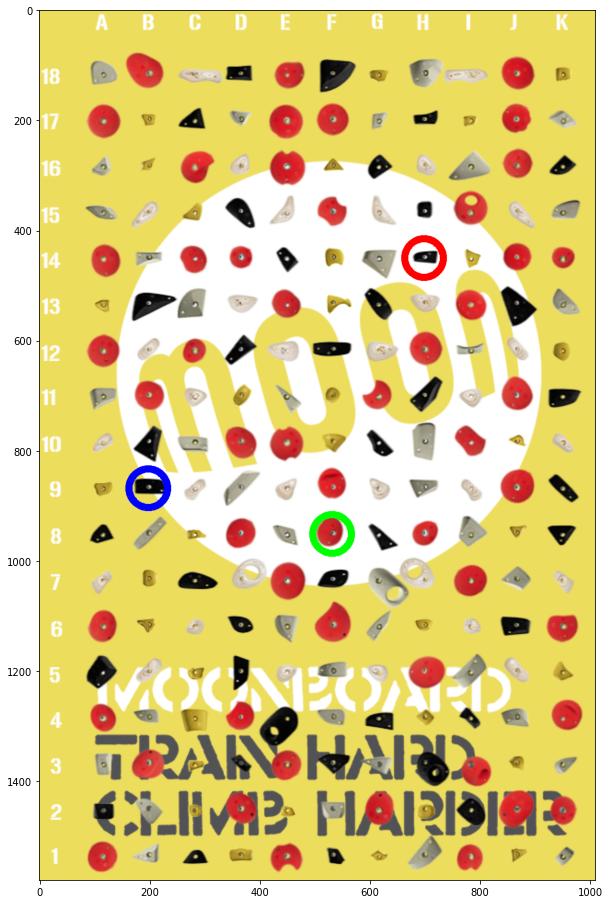

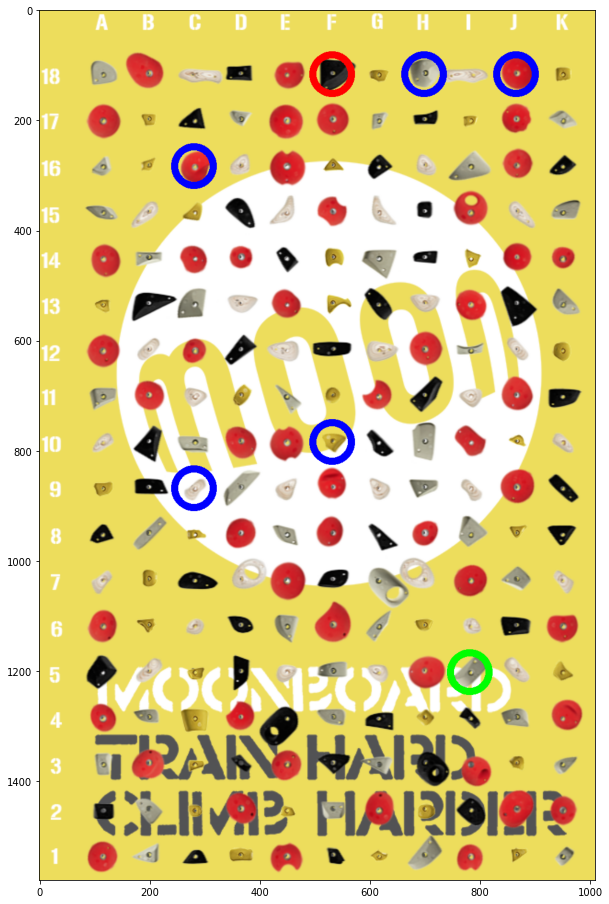

In [28]:
grades = t.Tensor([3]*5)
problems, imgs = generate_problems(grades, show=True)